In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

In [2]:



pd.set_option("display.max_rows", 25)

In [3]:
!wget -nc https://archive.ics.uci.edu/static/public/911/recipe+reviews+and+user+feedback+dataset.zip
!unzip -n recipe+reviews+and+user+feedback+dataset.zip

--2024-11-18 06:05:10--  https://archive.ics.uci.edu/static/public/911/recipe+reviews+and+user+feedback+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‚Äòrecipe+reviews+and+user+feedback+dataset.zip‚Äô

recipe+reviews+and+     [  <=>               ]   2.02M  9.16MB/s    in 0.2s    

2024-11-18 06:05:11 (9.16 MB/s) - ‚Äòrecipe+reviews+and+user+feedback+dataset.zip‚Äô saved [2114088]

Archive:  recipe+reviews+and+user+feedback+dataset.zip
  inflating: Recipe Reviews and User Feedback Dataset.csv  


In [4]:
recipes = pd.read_csv('/content/Recipe Reviews and User Feedback Dataset.csv')

## Feature Information

(Feature information taken directly from the UCI Machine Learning Repository page for Recipe Reviews and User Feedback page: https://archive.ics.uci.edu/dataset/911/recipe+reviews+and+user+feedback+dataset)
1. recipe name: {name of the recipe the comment was posted on}
2. recipe number: {placement of the recipe on the top 100 recipes list}
3. recipe code: {unique id of the recipe used by the site}
4. comment id: {unique id of the comment}
5. user id: {unique id of the user who left the comment}
6. user name: {name of the user}
7. user reputation: {internal score of the site, roughly quantifying the past behavior of the user}
8. create at: {time at which the comment was posted as a Unix timestamp}
9. reply count: {number of replies to the comment}
10. thumbs up: {number of up-votes the comment has received}
11. thumbs down: {number of down-votes the comment has received}
12. stars: {the score on a 1 to 5 scale that the user gave to the recipe. A score of 0 means that no score was given}
13. best score: {score of the comment, likely used by the site the help determine the order in the comments that appear in}
14. text: {the text content of the comment}

In [5]:
print(f'Number of observations: {recipes.shape[0]}')
print(f'Number of features: {recipes.shape[1]}')

Number of observations: 18182
Number of features: 15


In [6]:
recipes.describe()

Unnamed: 0  recipe_number    recipe_code  user_reputation  \
count  18182.000000   18182.000000   18182.000000     18182.000000   
mean     121.465295      38.689363   21773.667253         2.159608   
std      116.747893      29.786647   23965.109637        10.014666   
min        0.000000       1.000000     386.000000         0.000000   
25%       45.000000      12.000000    6086.000000         1.000000   
50%       91.000000      33.000000   14600.000000         1.000000   
75%      150.000000      64.000000   33121.000000         1.000000   
max      724.000000     100.000000  191775.000000       520.000000   

         created_at   reply_count     thumbs_up   thumbs_down         stars  \
count  1.818200e+04  18182.000000  18182.000000  18182.000000  18182.000000   
mean   1.623710e+09      0.014630      1.089264      0.549335      4.288802   
std    5.468697e+06      0.137974      4.201004      3.470124      1.544786   
min    1.613035e+09      0.000000      0.000000      0.000000      0.000000   
25%    1.622717e+09      0.000000      0.000000      0.000000      5.000000   
50%    1.622718e+09      0.000000      0.000000      0.000000      5.000000   
75%    1.622718e+09      0.000000      0.000000      0.000000      5.000000   
max    1.665756e+09      3.000000    106.000000    126.000000      5.000000   

         best_score  
count  18182.000000  
mean     153.162138  
std      141.075316  
min        0.000000  
25%      100.000000  
50%      100.000000  
75%      100.000000  
max      946.000000

In [7]:
nan_counts = recipes.isnull().sum()

print(nan_counts)

Unnamed: 0         0
recipe_number      0
recipe_code        0
recipe_name        0
comment_id         0
user_id            0
user_name          0
user_reputation    0
created_at         0
reply_count        0
thumbs_up          0
thumbs_down        0
stars              0
best_score         0
text               2
dtype: int64


In [8]:
recipes.dropna(inplace=True)

In [9]:
nan_counts = recipes.isnull().sum()

print(nan_counts)

Unnamed: 0         0
recipe_number      0
recipe_code        0
recipe_name        0
comment_id         0
user_id            0
user_name          0
user_reputation    0
created_at         0
reply_count        0
thumbs_up          0
thumbs_down        0
stars              0
best_score         0
text               0
dtype: int64


In [10]:
recipes.head(5)

Unnamed: 0  recipe_number  recipe_code         recipe_name  \
0           0              1        14299  Creamy White Chili   
1           1              1        14299  Creamy White Chili   
2           2              1        14299  Creamy White Chili   
3           3              1        14299  Creamy White Chili   
4           4              1        14299  Creamy White Chili   

                                        comment_id         user_id  \
0  sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM  u_9iFLIhMa8QaG   
1  sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY  u_Lu6p25tmE77j   
2  sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP  u_s0LwgpZ8Jsqq   
3  sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC  u_fqrybAdYjgjG   
4  sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI  u_XXWKwVhKZD69   

    user_name  user_reputation  created_at  reply_count  thumbs_up  \
0     Jeri326                1  1665619889            0          0   
1     Mark467               50  1665277687            0          7   
2  Barbara566               10  1664404557            0          3   
3  jeansch123                1  1661787808            2          2   
4    camper77               10  1664913823            1          7   

   thumbs_down  stars  best_score  \
0            0      5         527   
1            0      5         724   
2            0      5         710   
3            0      0         581   
4            0      0         820   

                                                text  
0  I tweaked it a little, removed onions because ...  
1  Bush used to have a white chili bean and it ma...  
2  I have a very complicated white chicken chili ...  
3  In your introduction, you mentioned cream chee...  
4  Wonderful! I made this for a &#34;Chili/Stew&#...

In [11]:
recipes.iloc[0]['text']

'I tweaked it a little, removed onions because of onion haters in my house, used Italian seasoning instead of just oregano, and use a paprika/ cayenne mix and a little more than the recipe called for.. we like everything a bit more hot. The chili was amazing! It was easy to make and everyone absolutely loved it. It will now be a staple meal in our house.'

In [12]:
revLenCol = []
for index, row in recipes.iterrows():
  revLenCol.append(len(row['text']))
recipes['text_len'] = revLenCol

In [13]:
recipes.shape

(18180, 16)

## Exploring a single user

In [14]:
user_freq = recipes['user_id'].value_counts()
user_freq

user_id
u_1oKVZzipo1u8lcqQzDUcw4UBn9e    25
u_1oKVZoIOMWJ2j7TA7py2BIbf1mm    23
u_1oKVeN9YNf07RT0P9R63Yu80P5A    23
u_1oKVZdmUbQTYMVdbXOpVfRQuHm9    23
u_1oKVZmYPulmUFbvGiBA8U3uRR6D    23
                                 ..
u_1oKb0Z7GaK3qgddIvHBE51aGpNR     1
u_1oKXqQP8GJ5iUglUxE9w7R7sNIz     1
u_1oKVeDE5LgvPWNlhcHCrJ4BSb2a     1
u_1oKZwWXHUaGO1Ns9K82Qd96ohyP     1
u_1oKVbnueXfnlmYWuYH8xJ0mFxNQ     1
Name: count, Length: 13812, dtype: int64

In [15]:
recipes['user_id'].value_counts().describe()
# vast majority of users have left only one comment

count    13812.000000
mean         1.316247
std          1.176873
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         25.000000
Name: count, dtype: float64

In [16]:
user = 'u_1oKVZoIOMWJ2j7TA7py2BIbf1mm'
user_comments = recipes[recipes['user_id'] == user]
display(user_comments.shape)
display(user_comments.head(4))

(23, 16)

Unnamed: 0  recipe_number  recipe_code  \
198          198              1        14299   
1591         428              3         2832   
2004         116              4        17826   
2377         151              5        42386   

                                            recipe_name  \
198                                  Creamy White Chili   
1591                                  Cheeseburger Soup   
2004                          Amish Breakfast Casserole   
2377  Pumpkin Spice Cupcakes with Cream Cheese Frosting   

                      comment_id                        user_id user_name  \
198   sp_aUSaElGf_14299_c_274376  u_1oKVZoIOMWJ2j7TA7py2BIbf1mm    mjlouk   
1591   sp_aUSaElGf_2832_c_129814  u_1oKVZoIOMWJ2j7TA7py2BIbf1mm    mjlouk   
2004  sp_aUSaElGf_17826_c_338332  u_1oKVZoIOMWJ2j7TA7py2BIbf1mm    mjlouk   
2377  sp_aUSaElGf_42386_c_340730  u_1oKVZoIOMWJ2j7TA7py2BIbf1mm    mjlouk   

      user_reputation  created_at  reply_count  thumbs_up  thumbs_down  stars  \
198                 1  1622717685            0          0            0      5   
1591                1  1622716984            0          0            0      4   
2004                1  1622717987            0          1            0      5   
2377                1  1622718015            0          0            0      4   

      best_score                                               text  text_len  
198          100  So good!  My husband and I really liked it!  B...        85  
1591         100  DH and I liked it but my kids wouldn&#39;t eve...       116  
2004         193  This was great!  I used ricotta instead of cot...       139  
2377         100  This was really good, even though I cheated an...        94

In [17]:
user_comments.describe()

Unnamed: 0  recipe_number    recipe_code  user_reputation  \
count   23.000000      23.000000      23.000000             23.0   
mean   100.217391      46.956522   29133.869565              1.0   
std     84.553349      30.805074   41570.062587              0.0   
min     20.000000       1.000000     414.000000              1.0   
25%     56.000000      22.000000    7106.000000              1.0   
50%     74.000000      50.000000   17826.000000              1.0   
75%    110.500000      69.500000   35223.500000              1.0   
max    428.000000      99.000000  191775.000000              1.0   

         created_at  reply_count  thumbs_up  thumbs_down      stars  \
count  2.300000e+01    23.000000  23.000000    23.000000  23.000000   
mean   1.622715e+09     0.043478   0.347826     0.043478   4.521739   
std    1.434069e+04     0.208514   0.647281     0.208514   0.665348   
min    1.622649e+09     0.000000   0.000000     0.000000   3.000000   
25%    1.622717e+09     0.000000   0.000000     0.000000   4.000000   
50%    1.622718e+09     0.000000   0.000000     0.000000   5.000000   
75%    1.622718e+09     0.000000   0.500000     0.000000   5.000000   
max    1.622718e+09     1.000000   2.000000     1.000000   5.000000   

       best_score    text_len  
count   23.000000   23.000000  
mean   129.478261  110.521739  
std     52.840988   81.146259  
min    100.000000   25.000000  
25%    100.000000   49.500000  
50%    100.000000  101.000000  
75%    146.500000  139.000000  
max    253.000000  407.000000

<Axes: >

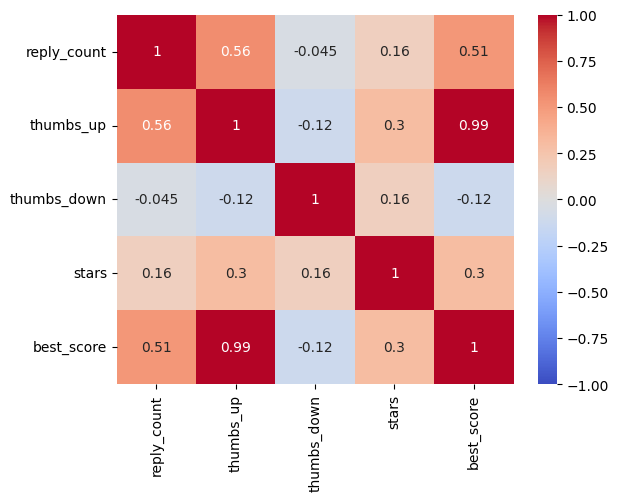

In [18]:
user_comments1 = user_comments[['reply_count', 'thumbs_up', 'thumbs_down', 'stars', 'best_score']]
sns.heatmap(user_comments1.corr(), annot = True, vmin=-1, vmax=1, center= 0,cmap='coolwarm')

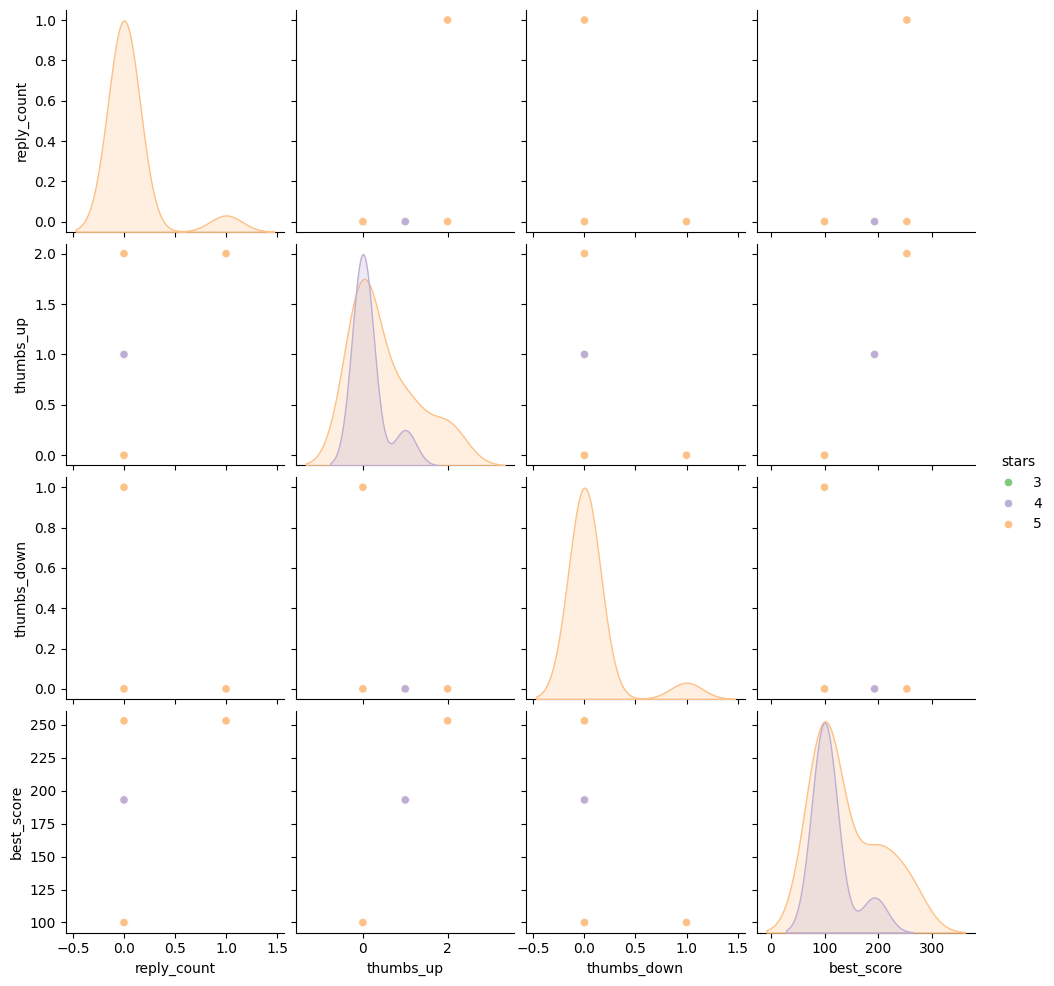

In [19]:
sns.pairplot(user_comments1, hue='stars', palette='Accent')

# Exploring a single recipe

In [20]:
recipes['recipe_code'].value_counts()

recipe_code
2832     724
14299    654
3309     509
42083    421
32480    397
        ... 
27675     96
1821      90
3683      86
34347     86
17022     31
Name: count, Length: 100, dtype: int64

As the recipe_code is the unique identifier for a given recipe in the dataset, we can use value_counts() in order to explore how often recipes were reviewed by individuals in this dataset. The counts highlight that the minimum number of reviews received was 31 with the maximum being 725.

In [21]:
recipes['recipe_code'].value_counts().describe()

count    100.000000
mean     181.800000
std      106.732177
min       31.000000
25%      128.000000
50%      149.000000
75%      191.750000
max      724.000000
Name: count, dtype: float64

Furthermore, we look at the summary statistics to highlight the typical number of reviews that a recipe would receive within this dataset. Utilizing the mean and standard deviation, we can see that 50% of the reviews in this dataset received between 75 and 287 reviews.

In [22]:
r_code = 3309 #r_code for "Best Ever Banana Bread"
chosen_recipe_reviews = recipes[recipes['recipe_code'] == r_code]
display(chosen_recipe_reviews.shape)
display(chosen_recipe_reviews.head(10))

(509, 16)

Unnamed: 0  recipe_number  recipe_code             recipe_name  \
654           0              2         3309  Best Ever Banana Bread   
655           1              2         3309  Best Ever Banana Bread   
656           2              2         3309  Best Ever Banana Bread   
657           3              2         3309  Best Ever Banana Bread   
658           4              2         3309  Best Ever Banana Bread   
659           5              2         3309  Best Ever Banana Bread   
660           6              2         3309  Best Ever Banana Bread   
661           7              2         3309  Best Ever Banana Bread   
662           8              2         3309  Best Ever Banana Bread   
663           9              2         3309  Best Ever Banana Bread   

                                         comment_id         user_id  \
654  sp_aUSaElGf_3309_c_2FolwA0WHirT2q7DDTqyFJ0GvGR  u_fjZn9UjnYY9Y   
655  sp_aUSaElGf_3309_c_2Ep40E2YQon3AZ6OBn6AzjlOUgc  u_qW2rjMVr5SYl   
656  sp_aUSaElGf_3309_c_2CWVCrfxczs1PGguLbIdM8r88A3  u_iWjGINSSoqyU   
657  sp_aUSaElGf_3309_c_2CBnWlxTIM2CGJ64QmWioAeAAop  u_j6XdnbRT1vtZ   
658  sp_aUSaElGf_3309_c_29vulYmOzERr8m6p1G9qbK3viNC  u_f2qPJ3428ktq   
659  sp_aUSaElGf_3309_c_29XwzUPWVbOp8GBLSXh5bEUAiNc  u_RKjgrUNMQ2nL   
660  sp_aUSaElGf_3309_c_28oSUFIyMS5O0XCRvOoxBcHs1IY  u_3sizCBCgDxYv   
661  sp_aUSaElGf_3309_c_28E25mUNpj5EtSosg5szn9jn8Av  u_lWOi5Uvd2Crc   
662  sp_aUSaElGf_3309_c_26sxNJFIsm6NTGmS8herPP3EqUT  u_XzUnohKrX5xj   
663  sp_aUSaElGf_3309_c_25fGq9WwhfmiXO7A3hmzhBCVBsT  u_nWwqfttBORnl   

             user_name  user_reputation  created_at  reply_count  thumbs_up  \
654          ritajandj                1  1665166553            0          0   
655          mrscessna               50  1663278966            0          0   
656       danielleylee               10  1658918203            0          8   
657           Joan9859               70  1658284879            0          6   
658         dcscake_OH               20  1654006031            0          4   
659            Jody939                1  1653273000            0          6   
660          inotsmile                1  1651881458            0         12   
661  KristineChayes576               50  1650767243            0          3   
662  jkhafer@yahoo.com                1  1648498961            0         11   
663         Raynebow68                1  1645910916            0          5   

     thumbs_down  stars  best_score  \
654            0      5         510   
655            0      4         488   
656            0      5         825   
657            1      5         750   
658            0      5         759   
659            1      5         759   
660            3      5         763   
661            0      5         710   
662            1      5         804   
663            1      5         728   

                                                  text  text_len  
654  This is the best recipe for banana bread I&#39...       381  
655      sweet and moist!  I will be making this again        45  
656  I made this bread with one minor twist. I live...       554  
657  In place of the 1/2 cup of oil, I used another...       126  
658  Made this for my book club, but used sour crea...       138  
659  This recipe has an amazing flavor.  I did chan...       484  
660  I have made this recipe several times.  My fam...       445  
661  Best Ever Banana Bread is a great recipe! No a...        66  
662  Add 1 tsp cinnamon to dry ingredients and it m...        80  
663  Best banana bread ever. Used pecans instead of...       112

To explore what a given recipe looks like, we selected the recipe associated with recipe_code 3309. This is the "Best Ever Banana Bread" recipe which has 509 reviews left on it. We can utilize this recipe as an example of the information we can extract from a single recipe and the individuals who interacted with it.

In [23]:
chosen_recipe_reviews.value_counts('stars',sort=False)

stars
0     24
1      7
2      7
3      8
4     25
5    438
Name: count, dtype: int64

Here we can see the distribution of ratings applied by users to this recipe. Before looking at the descriptive statistics, it is clear that users tend to rate this recipe 5/5 stars.

In [24]:
chosen_recipe_reviews['stars'].describe()

count    509.000000
mean       4.587426
std        1.211298
min        0.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: stars, dtype: float64

<Axes: xlabel='stars', ylabel='count'>

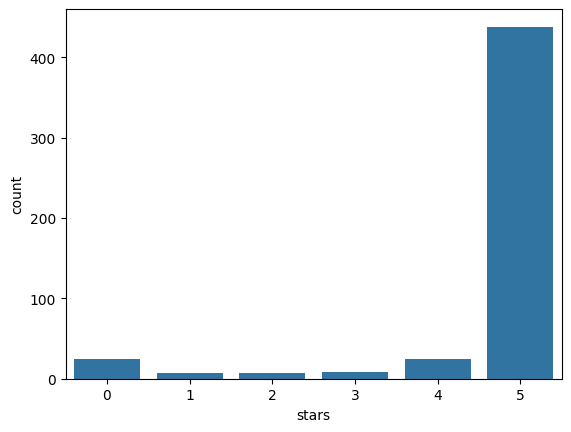

In [25]:
sns.countplot(data=chosen_recipe_reviews, x='stars')

In [26]:
len_text = []

for index,row in chosen_recipe_reviews.iterrows():
  len_text.append(len(row['text']))

chosen_recipe_reviews['text_len'] = len_text

<ipython-input-26-8529c5bb86a7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_recipe_reviews['text_len'] = len_text


In [27]:
chosen_recipe_reviews

Unnamed: 0  recipe_number  recipe_code             recipe_name  \
654            0              2         3309  Best Ever Banana Bread   
655            1              2         3309  Best Ever Banana Bread   
656            2              2         3309  Best Ever Banana Bread   
657            3              2         3309  Best Ever Banana Bread   
658            4              2         3309  Best Ever Banana Bread   
...          ...            ...          ...                     ...   
1158         504              2         3309  Best Ever Banana Bread   
1159         505              2         3309  Best Ever Banana Bread   
1160         506              2         3309  Best Ever Banana Bread   
1161         507              2         3309  Best Ever Banana Bread   
1162         508              2         3309  Best Ever Banana Bread   

                                          comment_id  \
654   sp_aUSaElGf_3309_c_2FolwA0WHirT2q7DDTqyFJ0GvGR   
655   sp_aUSaElGf_3309_c_2Ep40E2YQon3AZ6OBn6AzjlOUgc   
656   sp_aUSaElGf_3309_c_2CWVCrfxczs1PGguLbIdM8r88A3   
657   sp_aUSaElGf_3309_c_2CBnWlxTIM2CGJ64QmWioAeAAop   
658   sp_aUSaElGf_3309_c_29vulYmOzERr8m6p1G9qbK3viNC   
...                                              ...   
1158                       sp_aUSaElGf_3309_c_320144   
1159                       sp_aUSaElGf_3309_c_372056   
1160                       sp_aUSaElGf_3309_c_242245   
1161                       sp_aUSaElGf_3309_c_119354   
1162                       sp_aUSaElGf_3309_c_229159   

                            user_id     user_name  user_reputation  \
654                  u_fjZn9UjnYY9Y     ritajandj                1   
655                  u_qW2rjMVr5SYl     mrscessna               50   
656                  u_iWjGINSSoqyU  danielleylee               10   
657                  u_j6XdnbRT1vtZ      Joan9859               70   
658                  u_f2qPJ3428ktq    dcscake_OH               20   
...                             ...           ...              ...   
1158  u_1oKVeHuqdSi3qtGpC4CAQtwoMyk       lsarets                1   
1159  u_1oKbcjlgoks8YZXEacSMP9ctRfs      pamela39                1   
1160  u_1oKVjITIzZrIwoHcLYNUd4lP021        lssrls                1   
1161  u_1oKVZbmXe034ZVsauDi7AuMVJCI         Joscy                1   
1162  u_1oKVa4pymHH85u4w1wB9rKDNm9E       FriedaG                1   

      created_at  reply_count  thumbs_up  thumbs_down  stars  best_score  \
654   1665166553            0          0            0      5         510   
655   1663278966            0          0            0      4         488   
656   1658918203            0          8            0      5         825   
657   1658284879            0          6            1      5         750   
658   1654006031            0          4            0      5         759   
...          ...          ...        ...          ...    ...         ...   
1158  1622717927            0          0            0      5         100   
1159  1622718171            0          0            0      5         100   
1160  1622717545            0          0            0      5         100   
1161  1622716936            0          0            0      5         100   
1162  1622717501            0          1            0      5         193   

                                                   text  text_len  
654   This is the best recipe for banana bread I&#39...       381  
655       sweet and moist!  I will be making this again        45  
656   I made this bread with one minor twist. I live...       554  
657   In place of the 1/2 cup of oil, I used another...       126  
658   Made this for my book club, but used sour crea...       138  
...                                                 ...       ...  
1158  This is truly the best ever banana bread.  Ver...        66  
1159  Wonderful recipe! Best Banana Bread I&#39;ve e...       156  
1160  Made this for the first time and it is delicio...        83  
1161  Best Ever Banana Bread is a 

After extracting the lengths of the reviews for this recipe, we can preliminarily visualize whether there is a relationship between review length and given score. This is just one example of how we could extract information from the review text feature and then use it to predict recipe rating.

<Axes: xlabel='text_len', ylabel='stars'>

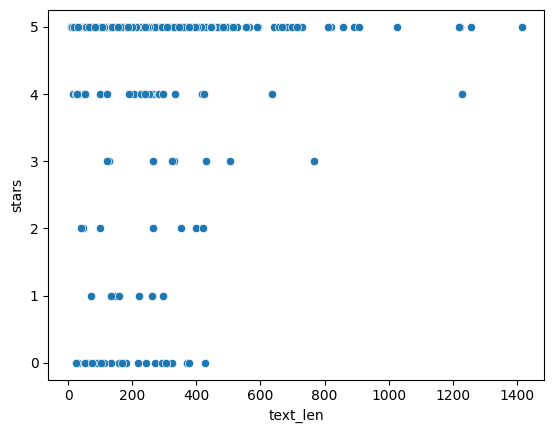

In [28]:
sns.scatterplot(data=chosen_recipe_reviews, x='text_len', y='stars')

# Combining Users and Recipes

In [29]:
usersPerRecipe = defaultdict(set)
recipesPerUser = defaultdict(set)
recipeIDtoName = {}
userIDtoName = {}

for index,row in recipes.iterrows():
  recipe, user, recName, username = row['recipe_code'], row['user_id'], row['recipe_name'], row['user_name']
  recipeIDtoName[recipe] = recName
  userIDtoName[user] = username
  usersPerRecipe[recipe].add(user)
  recipesPerUser[user].add(recipe)

Here we are creating a dictionary which links the users of a given recipe to to a recipe_code as well as a dictionary which links reviews to a given user. This would allow for facilitating looking at overlaps between users who share common recipes reviewed.

In [30]:
currentRecipe = 2832
print(recipeIDtoName[currentRecipe])
usersPerRecipe[currentRecipe]

Cheeseburger Soup


{'u_14Jt3Onn7vE8',
 'u_1JqI0KynEApl',
 'u_1oKVZXzP64U03Y1r3DIJ5He5wZl',
 'u_1oKVZaxgZr9JqCUTsowfyIT48aS',
 'u_1oKVZbbOJiAxmbAxRUolzjUrKDi',
 'u_1oKVZbcNg5NYW87grfhDXNePwbL',
 'u_1oKVZdntxwYzxksw1IqW0kld9jH',
 'u_1oKVZfQBhgRUCOwfHv6F4RA51zQ',
 'u_1oKVZg1DVmIpML6RYl0Vhh6hcJm',
 'u_1oKVZibiPJd5Mv0tuRswBqWOVWD',
 'u_1oKVZj2JQOqYRqPmcdZsFtwNOrx',
 'u_1oKVZj4aBY2EoyywYL0bjfbagtL',
 'u_1oKVZjBYxHQxhJkgDmxTGIXTCIG',
 'u_1oKVZjgpdznQpEBEtXA1bOrmzL0',
 'u_1oKVZmYPulmUFbvGiBA8U3uRR6D',
 'u_1oKVZoIOMWJ2j7TA7py2BIbf1mm',
 'u_1oKVZoZ2m9nE7bLNmSXNw4MdYcU',
 'u_1oKVZpdzBp5PQHOM4PGQOZo1ujc',
 'u_1oKVZskcWCF2NqqbEvMCAEXAZIG',
 'u_1oKVZtSdpfy5KrVbAXHeHU0QI4v',
 'u_1oKVZuqBVMf8IBAX9Lp2wMHJFOL',
 'u_1oKVZvcir01Ja6U1XIczcrh8mbP',
 'u_1oKVZw7mrwjQMxXSztLnhcVRC0b',
 'u_1oKVZxAOR5BEzyF4H6ENc7jwfUW',
 'u_1oKVZxNyweYeP3lQTMS89TQLWg3',
 'u_1oKVZzipo1u8lcqQzDUcw4UBn9e',
 'u_1oKVa1vU0P0wtIMwn8FBys0ptHj',
 'u_1oKVa2nlJX0DjsXaTen7cSJO3RY',
 'u_1oKVa3dm9k4sQJZuEACIlelurOi',
 'u_1oKVa4NSseUH7Ypn2zzEhhCFguB',
 'u_1oKVa5

Looking at recipe_code 2832 (Cheeseburger Soup) we can see that there a significant number of users who have left reviews on this particular recipe. We can then select from this list of users to see if there are further overlaps within their reviews.

In [31]:
currentUser1 = 'u_1oKVZoIOMWJ2j7TA7py2BIbf1mm'
print(userIDtoName[currentUser1])
recipesPerUser[currentUser1]

mjlouk


{414,
 957,
 2832,
 3143,
 4444,
 6504,
 7708,
 9735,
 14299,
 15805,
 16579,
 17826,
 18341,
 18345,
 19201,
 27434,
 32264,
 38183,
 39545,
 42083,
 42386,
 100276,
 191775}

In [32]:
currentUser2 = 'u_1oKVa6DRYXqOVPHLzyZwE55UjOh'
print(userIDtoName[currentUser2])
recipesPerUser[currentUser2]

lilaccrew


{2832, 39549}

In [33]:
recipeIDtoName[39549]

'Forgotten Jambalaya'

We can then compare mjlouk and lilaccrew and their preferences for recipes. More specifically, since both of these individuals left reviews on this cheeseburger soup recipe; we can then extend the question to whether or not each of the individual users would be interested in the other recipes which the other person left reviews on. Since lilaccrew also left a review on the Forgotten Jambalaya, there is a likelihood that mjlouk might also.

# TF-IDF Generation

In [34]:
!pip install fuzzywuzzy

In [35]:
!pip install pyspellchecker

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6.8/6.8 MB 40.5 MB/s eta 0:00:00


In [36]:
import string
from fuzzywuzzy import fuzz
from spellchecker import SpellChecker

# Function to replace incorrect words with correct ones
def replace_incorrect_words(text, corrections):
    for incorrect, correct in corrections.items():
        text = text.replace(incorrect, correct)
    return text

#Function to clean text
def clean_and_tokenize(text):
    remove_chars = string.punctuation
    translator = str.maketrans('', '', remove_chars)
    # Remove punctuation and digits, convert to lower case, and split into words
    words = text.translate(translator).lower()
    return words

def preprocess_correct_words(correct_words):
    word_dict = defaultdict(list)
    for word in correct_words:
        key = word[0]  # Grouping by the first letter
        word_dict[key].append(word)
    return word_dict

def correct_typos(text, word_dict, threshold=70):
    words = text.split()
    corrected_words = []
    for word in words:
        key = word[0]
        corrected = False
        for correct_word in word_dict[key]:
            if fuzz.ratio(word.lower(), correct_word.lower()) > threshold:
                corrected_words.append(correct_word)
                corrected = True
                break
        if not corrected:
            corrected_words.append(word)
    return ' '.join(corrected_words)

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [37]:
# This cell is used to check the original improper words.
cleaned_recipes = recipes.copy()

# Clean text from punctuation and capitalization
cleaned_recipes['text'] = cleaned_recipes['text'].apply(clean_and_tokenize)

all_text = ' '.join(cleaned_recipes['text'])
all_words = all_text.split()
unique_words = set(all_words)
unique_words_list = list(unique_words)


spell = SpellChecker()
misspelled_words = spell.unknown(unique_words_list)

print(f'Incorect Word Count: {len(misspelled_words)}')
print(misspelled_words)

Incorect Word Count: 8459
{'34soupiness34', '34saucy34', 'doz', 'anyonei', 'creami', 'mmb', 'bater', 'mothinlaw', 'mashedwouldn39t', 'applles', 'jalapenos', 'lol', 'thati', 'bags34', 'june', 'macarooni', 'beansmixed', 'h39burger', 'cornstartch', 'winnder', 'oreos', 'omgthese', 'iother', 'alsothe', 'delowenstein', 'basilto', '‚Äúchowdah‚Äù', 'bonein', 'extrmely', 'should‚Äôve', 'seraching', 'tipdidn39t', 'easymoistnow', 'anyday', 'picky3', 'premeasured', 'onceinawhile', 'indiana', 'fe', 'penzys', 'sm', 'tsuop', 'beautifuland', 'catalina', 'failproof', 'crustpart', 'soooooooooo', 'ohso', 'michel', 'refigerate', 'cupthese', 'deliciouslike', 'meatlaof', 'breadcakes', 'helpssue', '34go', 'olivestry', 'dinnerthis', 'sandwichp', 'crema', '‚Äúeat', 'leftoverschefleslie', 'allinone', 'hr', 'puddingi', 'buttershortening', 'substitutionsadditions', 'tasteused', 'moistcant', 'todaytaste', 'cheesey', 'timesi', 'minimuffins', 'glazeawsome', 'starth', '34th', 'spiceswhich', 'toomwparsons', 'pumpkinca

# Manual Cleaning

When correcting words like contractions such as "don't" or other words with apostrophes, I think we should just leave off the apostrophe. For example, correct "don't" to "dont" since we are removing all punctuation to perform tf-idf. Additionally some error text produces numbers combined with words. Just use best judgement to determine if the numbers are actually important or are just erroneous text.

In [38]:
# This dictionary is for separating words that are incorrectly combined
# The key is the combined word and the value should be the words separated
# This dictionary should only be used to separate combined words and not to fix typos.
# Also using for number corruptions and shorthand (gr8 -> great)
corrections = {
    'chickenspinach': 'chicken spinach', 'cheesepeanut': 'cheese peanut', 'nervewracking': 'nerve-wracking', 'peppersdont': 'peppers dont', 'doublechecked': 'double-checked',
    'creamcheese': 'cream cheese', 'anyday': 'any day', 'allday': 'all day', 'everytime': 'every time', 'milkcream': 'milk cream', 'coffeewater': 'coffee water',
    'likethis': 'like this', 'mixthis': 'mix this', '9year': '9 year', 'foodgood': 'food good', 'addchange': 'add change', 'havecooked': 'have cooked', 'cookedthese': 'cooked these',
    'recipecutting': 'recipe cutting', 'cakedessert': 'cake dessert', 'onceinawhile': 'once in a while', 'ourfriends': 'our friends',
    'deliciousdefinitely': 'delicious definitely', 'myfamily': 'my family', 'fillingdifferent': 'filling different', 'platethis': 'plate this', 'gettogether': 'get together',
    'easytomake': 'easy to make', 'toolittle': 'too little', 'coldweather': 'cold weather', 'juiceawesome': 'juice awesome',
    'amazingmake': 'amazing make', 'sweetespecially': 'sweetespecially', 'bruncheveryone': 'brunch everyone', 'texturekids': 'texture kids', 'supereasy': 'super easy',
    'afterthe wedding': 'after the wedding', 'chinesestyle': 'chinese-style', 'itadded': 'it added', 'bakednote': 'baked note', 'questionwhat': 'question what', 'bestif': 'best if',
    'piesbecause': 'pies because', 'sisiterinlaw': 'sister-in-law', '12on': '12 on', 'okthanks': 'ok thanks', 'mixedfrom': 'mixed from', 'chewycrispy': 'chewy crispy',
    'versionthen': 'version then', 'wantsneeds': 'wants needs', '59oz': '59 oz', 'againthough': 'again though', '8x8inch': '8x8 inch', '4tsp': '4 tsp', 'miniloaf': 'mini loaf',
    'gumbolike': 'gumbo-like', 'omgosh': 'oh my gosh', 'exceptthe': 'except the', 'thisit39s': 'this is', 'hotspicy': 'hot spicy', 'sorrybut': 'sorry but', 'sweetespecially': 'sweet especially',
    'recipemeaning': 'recipe meaning', 'flavorand': 'flavor and', 'bookclub': 'book-club', 'parchmentwax': 'parchment wax', 'bacontasted': 'bacon tasted', '350¬∞': '350 degrees',
    'pecansmaybe': 'pecans maybe', 'yolkwater': 'yolk water', 'entreevery': 'entree very', 'saucehad': 'sauce had', 'suggestionsthoughts': 'suggestions thoughts', 'substitutionsi': 'substitutions I',
    'crockpot': 'crock-pot', 'lowcalorie': 'low calorie', 'buttermicrowaves': 'butter microwaves',
    'theseput': 'these put',
    'brothkicked': 'broth kicked',
    'desertwill': 'desert will',
    'cheesethat': 'cheese that',
    'chilisoup': 'chili soup',
    'poppyseeds': 'poppy seeds',
    'differenttypes': 'different types',
    'shreddedreally': 'shredded really',
    'mixvery': 'mix very',
    'potput': 'pot put',
    'awesomedelicious': 'awesome delicious',
    'stepbystep': 'step-by-step',
    'moremaybe': 'more maybe',
    'hadsuper': 'had super',
    'triedandtrue': 'tried and true',
    'doughboys': 'dough boys',
    'partskim': 'part skim',
    'pepperthen': 'pepper then',
    'nightwas': 'night was',
    'functioneven': 'function even',
    'patinthepan': 'pat in the pan',
    'flourthey': 'flour they',
    '12oz': '12 oz',
    'cauliflowerbetter': 'cauliflower better',
    'toomakes': 'too makes',
    'seasoningsperfecto': 'seasonings perfecto',
    'thanksjen': 'thanks jen',
    'breadrolls': 'bread rolls',
    'offthat': 'off that',
    'saidexcept': 'said except',
    'aprilmay': 'april may',
    'sauceyummy': 'sauce yummy',
    'jelloif': 'jello if',
    '8yearold': '8-year-old',
    'timenot': 'time not',
    'carrotpea': 'carrot pea',
    'nowthe': 'now the',
    'correctlythey': 'correctly they',
    'crowdwhen': 'crowded when',
    'isit': 'is it',
    'sugarspice': 'sugar spice',
    'splitingcracking': 'splitting cracking',
    'workthis': 'work this',
    'browningalso': 'browning also',
    'toppingwaste': 'topping waste',
    'zucchinimy': 'zucchini my',
    'amishmennonite': 'amish mennonite',
    'imade': 'I made',
    'trayspoured': 'trays poured',
    'rouxbased': 'roux-based',
    'coarselychopped': 'coarsely chopped',
    'breezeto': 'breeze to',
    '18month': '18 month',
    'zucchinihating': 'zucchini hating',
    'tastymoist': 'tasty moist',
    'pieswhich': 'pies which',
    'pecanswalnuts': 'pecans walnuts',
    'wellmaybe': 'well maybe',
    'sisinlaw': 'sis-in-law',
    'cakedont': 'cake dont',
    'thisnormally': 'this normally',
    'creamystyle': 'creamy style',
    'goldenbrown': 'golden-brown',
    'degreesso': 'degrees so',
    'itnever': 'it never',
    'recipemmmmmmmmmmmmm': 'recipe mmmmmmmmmmmmm',
    'leftbig': 'left big',
    '34tops34': 'tops',
    '34kick34': 'kick',
    '34why34': 'why',
    '39green39': 'green',
    '34doctored34': 'doctored',
    '34let39s': 'lets',
    '39applesauce39': 'applesauce',
    '34poof34': 'poof',
    '34basket34': 'basket',
    '34wonderful34': 'wonderful',
    '39temper39': 'temper',
    '34special': 'special',
    '34sugar34': 'sugar',
    '34ton34': 'ton',
    '34bubble34': 'bubble',
    'preppingcutting': 'prepping cutting',
    'colorssadly': 'colors sadly',
    'flourwater': 'flour water',
    '2pound': '2 pound',
    'potatoesturned': 'potatoes turned',
    'thankyou': 'thank you',
    'heavyas': 'heavy as',
    'velveetaand': 'velveeta and',
    'potatoeswill': 'potatoes will',
    'gr8': 'great',
    'meatbean': 'meat bean',
    'oventhey': 'oven they',
    'overlydelicious': 'overly delicious',
    'bracesteeth': 'braces teeth',
    'chickenapple':'chicken apple',
    'phenomenallove': 'phenomenal love',
    'garnishgood': 'garnish good',
    'anybut': 'any but',
    'besurprised': 'be surprised',
    'olivesthe': 'olives the',
    'costeffectiveness': 'cost-effectiveness',
    'fullbodied': 'full-bodied',
    'cupcakesgrandma': 'cupcakes grandma',
    'bittook': 'bit took',
    'yogurtjello39s': 'yogurt jellos',
    'redfat': 'red fat',
    'makeand': 'make and',
    'andstir': 'and stir',
    '2gether': 'together',
    '3rd': 'third',
    'saucejuice': 'sauce juice',
    'amazingthis': 'amazing this',
    'itbecause': 'it because',
    'hand34': 'hand',
    'recipeyou': 'recipe you',
    'youstart': 'you start',
    'candylike': 'candy like',
    '34corn': 'corn',
    'soupfast': 'soup fast',
    'pepperjackcheddar': 'pepper jack cheddar',
    'piecesinstead': 'pieces instead',
    '34raw34': 'raw',
    'saladthank': 'salad thank',
    'fallwinter': 'fall winter',
    'amountenough': 'amount enough',
    '34hot34': 'hot',
    'it‚Ä¶does': 'it does',
    '34soup': 'soup',
    'secondsthey': 'seconds they',
    'servingadds': 'serving adds',
    '34from': 'from',
    'beautifuland': 'beautiful and',
    'familyfriends': 'family friends',
    'buttercream': 'butter cream',
    '34favorites34': 'favorites',
    '34after': 'after',
    'greattasting': 'great tasting',
    'recipedirections': 'recipe directions',
    'puddingdelicious': 'pudding delicious',
    'displayed39': 'displayed',
    'beautifulthank': 'beautiful thank',
    'birthdayfollowed': 'birthday followed',
    'myhouse': 'my house',
    'nofat': 'no fat',
    'soupsbased': 'soups based',
    'leafpumpkin': 'leaf pumpkin',
    'spicyuse': 'spicy use',
    'bitethen': 'bite then',
    'timeoverall': 'time overall',
    'chickencooking': 'chicken cooking',
    '34ground': 'ground',
    'outif': 'out if',
    'sugarperfect': 'sugar perfect',
    '34butter34': 'butter',
    'tasteeffect': 'taste effect',
    'recipeone': 'recipe one',
    '39companygood39': 'company good',
    'tastingit': 'tasting it',
    'turkey2': 'turkey',
    '34monster34': 'monster',
    '34recipe': 'recipe',
    '34extra': 'extra',
    'onionhamburger': 'onion hamburger',
    'esp': 'especially',
    'standards‚Äù': 'standards',
    'team39s': 'teams',
    '34pineapple': 'pineapple',
    'betterswitched': 'better switched',
    '34thank': 'thank',
    'beforeassembling': 'before assembling',
    '34thank': 'thank',
    'flourmaybe': 'flour maybe',
    'themspan': 'them span',
    'brownused': 'brown used',
    'timedemanding': 'time-demanding',
    'restaurantlovelyyummy': 'restaurant lovely yummy',
    'barlike': 'bar like',
    'sugarthanks': 'sugar thanks',
    'chickenvegetable': 'chicken vegetable',
    'butterbased': 'butter based',
    'menu39': 'menu',
    'sweetsalty': 'sweet salty',
    'prettyand': 'pretty and',
    '34basic': 'basic',
    'thiswonderful': 'this wonderful',
    'statecheeseburger': 'state cheeseburger',
    'ovenand': 'oven and',
    'comfortfood': 'comfort food',
    'saltbecause': 'salt because',
    'arewe': 'are we',
    'tender34': 'tender',
    'happylady': 'happy lady',
    'leftoverswhich': 'leftovers which',
    'slowcooker': 'slow cooker',
    'impressedthe': 'impressed the',
    'porcupinelooking': 'porcupine-looking',
    'onelove': 'one love',
    'bunsthis': 'buns this',
    'guiltfree': 'guilt-free',
    '39topping39': 'topping',
    'coworker39s': 'coworkers',
    'produce102014': 'produce',
    'enoughand': 'enough and',
    '34add': 'add',
    'fillingalso': 'filling also',
    'sweetrich': 'sweet rich',
    'cinnamonusing': 'cinnamon using',
    'pan34': 'pan',
    'greatevery': 'great every',
    'familythey': 'family they',
    'potatoesbacon': 'potatoes bacon',
    '34noodles34': 'noodles',
    'suggestedone': 'suggested one',
    'sidedish': 'side dish',
    'tastenot': 'taste not',
    'websiteone': 'website one',
    'feelingsenjoy': 'feelings enjoy',
    '34meatloaf': 'meatloaf',
    'againsoon': 'again soon',
    'onepeach': 'one peach',
    'publishedone': 'published one',
    'variety34': 'variety',
    'quanitytherefore': 'quanity therefore',
    'hotsweet': 'hot sweet',
    'onionsprinkled': 'onion sprinkled',
    'flakymoisture': 'flaky moisture',
    '39dough39': 'dough',
    'sometimessausage': 'sometimes sausage',
    'oneofmymostrequested': 'one of my most requested',
    'touchaway': 'touch away',
    '34cheesy': 'cheesy',
    'beef34': 'beef',
    'applesauceinstead': 'apple sauce instead',
    'falltime': 'fall time',
    '34comforting34': 'comforting',
    'sauce34': 'sauce',
    'microwavesafe': 'microwave safe',
    'selfconscious': 'self-conscious',
    '41122made': 'made',
    'say39s': 'says',
    'it‚Ä¶okay‚Ä¶changed': 'it okay changed',
    'added34': 'added',
    'breezepat': 'breeze pat',
    'granulesreally': 'granules really',
    'browncould': 'brown could',
    'hiteven': 'hit even',
    'afraidit': 'afraid it',
    'tonight39s': 'tonights',
    '9inch': '9 inch',
    'pea39s': 'peas',
    '34jiffy34': 'jiffy',
    'colbymonterey': 'colby monterey',
    'noboil': 'no boil',
    'greatkids': 'great kids',
    'ovenready': 'oven ready',
    'timesaving': 'time-saving',
    'citrustype': 'citrus type',
    '39maple': 'maple',
    '34test': 'test',
    'lunchsize': 'lunch size',
    'basenot': 'base not',
    'bestvery': 'best very',
    'lowsodium': 'low sodium',
    'thenplease': 'then please',
    'zucchinisincerely': 'zucchini sincerely',
    'deboned': 'de-boned',
    'cinnamonsugar': 'cinnamon sugar',
    'upstuffed': 'up stuffed',
    'itjust': 'it just',
    'liquidwet': 'liquid wet',
    'seedsmy': 'seeds may',
    'cornmeal1': 'cornmeal',
    'coolweather': 'cool weather',
    'cheesesadded': 'cheeses added',
    '34some': 'some',
    'andmight': 'and might',
    'recipeentire': 'recipe entire',
    'semihealthy': 'semi-healthy',
    'runningat': 'running at',
    'againthey': 'again they',
    '39doesn39t': 'doesnt',
    'oniongreen': 'onion green',
    'lockdown': 'lock down',
    'zucchiniworks': 'zucchini works',
    'cauliflowerand': 'cauliflower and',
    'roomtemp': 'room temp',
    'that39ll': 'thatll',
    'husband46041': 'husband',
    'thank39s': 'thanks',
    'tonightit': 'tonight it',
    'luckwhere': 'luck where',
    '34pickles': 'pickles',
    'recipedelicious': 'recipe delicious',
    'bowlabsolutely': 'bowl absolutely',
    'gravysauce': 'gravy sauce',
    '34ever34': 'ever',
    'pepperonion': 'pepper onion',
    'meatonions': 'meat onions',
    'flourused': 'flour used',
    'dayif': 'day if',
    'platesi': 'plaates I',
    'winterthanks': 'winter thanks',
    'zucchiniyou': 'zucchini you',
    'noodlesand': 'noodles and',
    'leftthank': 'left thank',
    '34his': 'his',
    '34crumbs34': 'crumbs',
    'souphave': 'soup have',
    'questioncould': 'question could',
    'raviloianother': 'ravioli another',
    'flourmilk': 'flour milk',
    'dinnereveryone': 'dinner everyone',
    'friendlyand': 'friendly and',
    'lasagnaand': 'lasagna and',
    'layersfor': 'layers for',
    '34fresh34': 'fresh',
    'makethat': 'make that',
    'mexiblend': 'mexican blend',
    'meatandpotato': 'meat and potato',
    'rice39': 'rice',
    'nutricious': 'nutritious',
    'pbampjs': 'pb and js',
    'france39s': 'frances',
    'pepper39s': 'peppers',
    'allout': 'all out',
    'overbakemine': 'overbake mine',
    '1cup': 'one cup',
    '34crock': 'crock',
    'bartholomew39s': 'bartholomews',
    '34rainbow': 'rainbow',
    'itfor': 'itfor',
    'tipdidn39t': 'tip didnt',
    'sauceand': 'sauce and',
    'foundthe': 'found the',
    'maketry': 'make try',
    '34looks': 'looks',
    'toojust': 'too just',
    'anytimes': 'any times',
    'casserole‚Äô': 'casserole',
    'peacheswill': 'peaches will',
    'muchi39ll': 'much ill',
    'beforei': 'before i',
    '34feels34': 'feels',
    '34casserole34': 'casserole',
    'creamstill': 'cream still',
    '34better': 'better',
    'minuteswhile': 'minutes while',
    'rice34': 'rice',
    'welland': 'well and',
    'goodi': 'good',
    'pik': 'pick',
    'andcame': 'and came',
    '\‚Äúcoffee\‚Äù': 'coffee',
    'momof3': 'mom of three',
    '\‚Äúslight': 'slight',
    'itwe': 'it we',
    'ughfor': 'ugh for',
    'bestmake': 'best make',
    'usedkey': 'used key',
    'forfantastic': 'for fantastic',
    '34fake34': 'fake',
    'children39s': 'children',
    'disposalnot': 'disposal not',
    'france39s': 'frances',
    'pepper39s': 'peppers',
    'sister-in-law': 'sister in law',
    'allout': 'all out',
    'overbakemine': 'overbake mine',
    '1cup': 'one cup',
    '34crock': 'crock',
    'grandfather39s': 'grandfathers',
    '34scalloped34': 'scalloped',
    'pie34': 'pie34',
    '1teaspoon': 'one teaspoon',
    'saladcool': 'salad cool',
    'afterthewedding': 'after the wedding',
    'makejanietaste': 'make janie taste',
    'corningware': 'corning ware',
    'event34': 'event',
    'thesethey': 'these they',
    'fajitasthat': 'fajitas that',
    'everyone\‚Äôs': 'everyones',
    'guy34': 'guy',
    'cookingand': 'cooking and',
    '34improve34': 'improve',
    '34charm34': 'charm',
    'makingfirst': 'making first',
    'dairyallergic': 'dairy allergic',
    '39on': 'on',
    'daythis': 'day this',
    'i39ll': 'ill',
    'cheesemilk': 'cheese mik',
    'neighborshowever': 'neighbors however',
    'knoweverything': 'know everything',
    'renovationwhen': 'renovation when',
    'inlaws39': 'inlaws',
    'cheesenext': 'cheese next',
    'contestwhen': 'contest when',
    'longjust': 'long just',
    'halfseemed': 'half seemed',
    'creamoverall': 'cream overall',
    'willtry': 'will try',
    'had34': 'had',
    'recipetruly': 'recipe truly',
    'lateryummy': 'later yummy',
    'selfrising': 'self rising',
    'ityes': 'it yes',
    'weekit': 'week it',
    'kristalcrystalsounded': 'kristal crystal sounded',
    'vegi39s': 'veggies',
    'workreceived': 'work received',
    '34muffin34': 'muffin',
    'refriedbeans': 'refried beans',
    'goodit': 'good it',
    'ediblei': 'edible i',
    'packingand': 'packing and',
    'i3939ll': 'ill',
    '34first34': 'first',
    'themespeciallyecially': 'them especially',
    'meateaters': 'meat eaters',
    'hellojust': 'hello just',
    'is34': 'is',
    'itmaybe': 'it maybe',
    'ideaspread': 'idea spread',
    'waterbullion1': 'water bullion',
    'bevery': 'be very',
    'delisheverybody': 'delicious everybody',
    'themthe': 'them the',
    'laterunless': 'later unless',
    'todayi': 'today i',
    'cheeseused': 'cheese used',
    'cookiethe': 'cookie the',
    'flavorthis': 'flavor this',
    'lngtime': 'long time',
    'zuke': 'zucchini',
    'bakinggoooooood': 'baking good',
    '2weeks': '2 weeks',
    'suggestedi': 'suggested i',
    'recipedid': 'recipe did',
    'potpoast': 'pot roast',
    'brotherinlaw': 'brother-in-law',
    'piewow': 'pie wow',
    'kidfriendly': 'kid friendly',
    'againloved': 'again loved',
    'tasteshope': 'tastes hope',
    'coffeeit': 'coffee it',
    'baget': 'baguette',
    'nonred': 'non-red',
    'handshredded': 'hand-shredded',
    'addeddoubled': 'added doubled',
    'ituntil': 'it until',
    'toppingnext': 'topping next',
    'olivesim': 'olives im',
    'itone': 'it one',
    'cakeahead': 'cake ahead',
    'beefturkey': 'beef turkey',
    'tastebuds': 'taste buds',
    'lotand': 'lot and',
    'year2021': 'year 2021',
    'workits': 'work its',
    'timedash': 'time dash',
    'tymeand': 'thyme and',
    'atnear': 'at near',
    'exactlythe': 'exactly the',
    'milkserved': 'milk served',
    'olivesim': 'olives im',
    'creamwhipping': 'cream whipping',
    'coleslawive': 'cole slaw ive',
    'glazeshould': 'glaze should',
    'makeagain': 'make again',
    'batchive': 'batch ive',
    'ohmygoodness': 'oh my goodness',
    '7per': '7 per',
    'allppit': 'all of it',
    'pthe': 'the',
    'thanx': 'thanks',
    '14cups': '14 cups',
    'homeit': 'home it',
    'conceptbut': 'concept but',
    'therefrigerated': 'the refrigerated',
    'crowdpleasing': 'crowd pleasing',
    'oniongarlic': 'onion garlic',
    'wellnext': 'well next',
    '2016the': '2016 the',
    'whiskeydrinkingcowgirl': 'whiskey drinking cowgirl',
    'amaazzzingmade': 'amazing made',
    'changeadd': 'change add',
    'stylestrips': 'style strips',
    'nonbaker': 'non-baker',
    'bonusdont': 'bonus dont',
    'wcrusty': 'crusty',
    'ur': 'your',
    'deglazed': 'de-glazed',
    'mashedwouldnt': 'mashed wouldnt',
    'gona': 'gonna',
    'applesthey': 'apples they',
    'recipeexcept': 'recipe except',
    'yoi':'you',
    'saltyi': 'salty i',
    'pillisbyoury': 'pillsbury',
    'thanksmore': 'thanks more',
    'bingoperfection': 'bingo perfection',
    'miniloaves': 'mini loaves',
    'aa': 'a',
    'flavordepth': 'flavor depth',
    'regularwould': 'regular would',
    'batchalways': 'batch always',
    'losti': 'lost i',
    'wgreen': 'green',
    'recipeveryone': 'recipe everyone',
    'bonusdont': 'bonus dont',
    'workbut': 'work but',
    'tastyeveryone': 'tasty everyone',
    'cinnamonlittle': 'cinnamon little',
    'firstplace': 'first place',
    'mashedwouldnt': 'mashed wouldnt',
    'thickenno': 'thicken no',
    'procedyoure': 'proceed youre',
    'floyourless': 'flourless',
    'bruttish': 'brutish',
    'coolmade': 'cool made',
    'nocook': 'no cook',
    'fiascorunny': 'fiasco runny',
    'powderspan': 'powders pan',
    'they‚Äôll': 'theyll',
    'flatgivee': 'flat give',
    'encoyourage': 'encourage',
    'isn¬¥t': 'isnt',
    'freshgrated': 'fresh grated',
    'soninlaw‚Äôs': 'son-in-laws',
    'byouried': 'buried',
    'soyour': 'sour',
    'daynot': 'day not',
    'oneyearold': 'one-year-old',
    'makemarilyncooks': 'make marilyn cooks',
    'splendalways': 'splendid always',
    'alreadyfor': 'already for',
    'timedelicious': 'time delicious',
    '5stars': '5 stars',
    "2teaspoon": '2 teaspoon',
    'dicedother': 'diced other',
    'sizeroom': 'size room',
    'mixthat': 'mix that',
    'nospend': 'no spend',
    'medelicious': 'me delicious',
    'resultstaste': 'results taste',
    'hotdish': 'hot dish',
    'nospend': 'no spend',
    'saiutade': 'sauteed',
    'toffeeguess': 'toffee guess',
    'flavorcakelike': 'flavor cake-like',
    'quickmake': 'quick make',
    'crackersit': 'crackers it',
    'easymine': 'easy mine',
    'isamazing': 'is amazing',
    'imagineseasoned': 'imagine seasoned',
    'marshmallowsprobably': 'marshmallows probably',
    'ithad': 'it had',
    'wellbiggest': 'well biggest',
    'approx': 'approximately',
    'dishother': 'dish other',
    'ciderbut': 'cider but',
    'rockcould': 'rock could',
    'warningthis': 'warning this',
    'peachycake': 'peachy cake',
    'laborintensive': 'labor intensive',
    'itthink': 'it think',
    'againicing': 'again icing',
    'sweetsimpletasty': 'sweet simple tasty',
    'peppergarlicmushrooms': 'pepper garlic mushrooms',
    'perfectbatter': 'perfect batter',
    'tricoloyour': 'tricolor your',
    'plsi': 'please',
    'cobblercake': 'cobbler cake',
    'perfectbest': 'perfect best',
    'halfrecipebaked': 'half recipe baked',
    'stareveryone': 'star everyone',
    'dessertsexpecially': 'desserts expecially',
    'exactlyii': 'exactly',
    'veggieihater': 'veggie hater',
    'likeperhaps': 'like perhaps',
    'conf': 'conference',
    'squasheggcheese': 'squash egg cheese',
    'presliced': 'pre-sliced',
    'longerbecause': 'longer because',
    'susie77i': 'susie',
    'quickeasy': 'quick easy',
    'onionsbacon': 'onions bacon',
    'thickenedreduced': 'thickened reduced',
    'tastesthank': 'tastes thank',
    'soupdefinitely': 'soup definitely',
    'awful‚Äú': 'awful',
    'wowtakes': 'wow takes',
    'aparagus': 'asparagus',
    'usthink': 'us think',
    'tomatospaghetti': 'tomato spaghetti',
    'soupfills': 'soup fills',
    'nightbut': 'night but',
    'sherrythis': 'sherry this',
    'wisethanks': 'wise thanks',
    'firsttime': 'first time',
    'worksbuy': 'works buy',
    'yogyourtraspberry': 'yogurt raspberry',
    'cupcakeslook': 'cupcakes look',
    'exactlydid': 'exactly did',
    'onesmy': 'ones my',
    'premade': 'pre-made',
    'exactlyoh': 'exactly oh',
    'recipethank': 'recipe thank',
    'waterremember': 'water remember',
    'oilone': 'oil one',
    'resultawesome': 'result awesome',
    'calorieseat': 'calories eat',
    'goodthe': 'good the',
    'toothanks': 'too thanks',
    'breadpudding': 'bread pudding',
    'cakein': 'cake in',
    'easywonderful': 'easy wonderful',
    'allvery': 'all very',
    'readytoeat': 'ready to eat',
    'joyournal': 'journal',
    'itwith': 'it with',
    'too‚Ä¶my': 'too my',
    'kidsnow': 'kids now',
    'familyperfect': 'family perfect',
    'crabmeat': 'crab meat',
    'shrimpimitationcrab': 'shrimp imitation crab',
    'perfectnext': 'perfect next',
    'flatgive': 'flat give',
    'corncake': 'corn cake',
    'glutenfree': 'gluten-free',
    'flavorwatch': 'flavor watch',
    'allergyfree': 'allergy free',
    'importantthe': 'important the',
    'structyoure': 'structure',
    'nowits': 'now its',
    'chicken‚Äùbetter': 'chicken better',
    'heartshaped': 'heart shaped',
    'onesboth': 'ones both',
    'icebyourg': 'ice by your',
    'usedthe': 'used the',
    'foyourths': 'fourths',
    'cupof': 'cup of',
    'coolchill': 'cool chill',
    'yearvolunteer': 'year volunteer',
    'crumblywould': 'crumbly would',
    'moststandard': 'most standard',
    'topbaked': 'top baked',
    'thatcons': 'that cons',
    'adjustmentsused': 'adjustments used',
    'themafter': 'the matter',
    'daywhole': 'day whole',
    'storebough': 'store bought',
    'griddy': 'gritty',
    'supermarketthis': 'supermarket this',
    'skinon': 'skin on',
    'hoyourchecked': 'how your checked',
    'comingretired': 'coming retired',
    'cinnamonexcellent': 'cinnamon excellent',
    'eighthinch': 'eighth inch',
    'whiphubby': 'whip hubby',
    'workbut': 'work but',
    'tomotoesawesome': 'tomatoes awesome',
    'teebut': 'tee but',
    'belowif': 'below if',
    'tyourkeydelicious': 'turkey delicious',
    'timesvery': 'times very',
    'appx': 'approximately',
    'mushybreadegg': 'mushy bread egg',
    'isbecause': 'is because',
    'anyonei': 'anyone i',
    'todaytyourned': 'today turned',
    'sisternlaw': 'sister-in-law',
    'tbls': 'tablespoons',
    'psubstitutions': 'substitutions',
    'panfried': 'pan fried',
    'servingsspanli': 'servings span li',
    'waysi': 'ways I',
    'softset': 'soft set',
    'fajijas': 'fajitas',
    'carrotsaving': 'carrot saving',
    'clams‚Ä¶': 'clams',
    'makegoing': 'make going',
    'buttershortening': 'butter shortening',
    'shrimpflavored': 'shrimp flavored',
    'stovethe': 'stove the',
    'tyourkeychopped': 'turkey chopped',
    'crumbsmost': 'crumbs most',
    'pyourpose': 'purpose',
    'ownwhen': 'own when',
    'creamcooked': 'cream cooked',
    'fatsugar': 'fat sugar',
    'crowdpleaser': 'crowd pleaser',
    'looksoundppthanksp': 'look sound thanks',
    'goodnessi': 'goodness i',
    'chowderthis': 'chowder this',
    'punget': 'pungent',
    'pumkpkin': 'pumpkin',
    'thowe': 'though',
    'wordfabulous': 'word fabulous',
    'flippin': 'flipping',
    'mostrequested': 'most requested',
    'pancook': 'pan cook',
    'dunkersare': 'dunkers are',
    'recipehence': 'recipe hence',
    'homrmade': 'homemade',
    'foilcookies': 'foil cookies',
    'inputthanks': 'input thanks',
    'timethey': 'time they',
    'featyoured': 'featured',
    'psuper': 'super',
    'oldyes': 'old yes',
    'casserolelayered': 'casserole layered',
    'sillygirl': 'silly girl',
    'antizucchini': 'anti-zucchini',
    'salsadelish': 'salsa delish',
    'garliccheese': 'garlic cheese',
    'itadding': 'it adding',
    '‚Äúbetter': 'better',
    'cuminspanili': 'cumin spanili',
    'allpurpose': 'all-purpose',
    'peppersit': 'peppers it',
    'handthis': 'hand this',
    'notedthe': 'noted the',
    'formin': 'for min',
    'cyourrently': 'currently',
    'schoolchyourch': 'school church',
    'timemade': 'time made',
    'piesit': 'pies it',
    'winwini': 'win win',
    'exmotherinlaw': 'ex-mother-in-law',
    'ontop': 'on top',
    'failproof': 'fail proof',
    'anywaylove': 'anyway love',
    'itands': 'it and',
    'thinki': 'thinking',
    'breaststhis': 'breasts this',
    'hardto': 'hard to',
    'tablespoonsps': 'tablespoons',
    'getoutofhere': 'get out of here',
    'extracttyourned': 'extract turned',
    'thx': 'thanks',
    'veggiesmeatspices': 'veggies meat spices',
    'recommendused': 'recommend used',
    'soninlaw': 'son-in-law',
    'acrossthestreet': 'across the street',
    'tasteflavor': 'taste flavor',
    'sitea': 'site',
    'parmesean': 'parmesan',
    'leanspanili': 'lean spanili',
    'exhusband': 'ex-husband',
    'puttingspan': 'putting span',
    'indeedjanietaste': 'indeed janie taste',
    'vanillavanilla': 'vanilla vanilla',
    'flavorsthank': 'flavors thank',
    'homecooked': 'home cooked',
    'winwin': 'win-win',
    'totellinidefrosted': 'to tell in defrosted',
    'itthank': 'it thank',
    'recipereally': 'recipe really',
    'respeciallyonse': 're specially on se',
    'itbut': 'it but',
    'thisfollowed': 'this followed',
    'exoerience': 'experience',
    'potatoescelerybaby': 'potatoes celery baby',
    'hambyourgers': 'hamburgers',
    'fatfree': 'fat free',
    'freshlygrated': 'freshly grated',
    'starsoft': 'stars of',
    'mustit': 'must it',
    '‚Äúfavorite‚Äù': 'favorite',
    'richwill': 'rich will',
    'tortelli': 'tortelli',
    'excellentfollowed': 'excellent followed',
    'healty': 'healthy',
    'greasefloyour': 'grease flour',
    'sugarfree': 'sugar free',
    'extrasharp': 'extra sharp',
    '350deg': '350 degrees',
    'hyourting': 'hurting',
    'sizesb': 'sizes',
    'postshare': 'post share',
    'oilhalf': 'oil half',
    'aislethe': 'aisle the',
    'hosses': 'hosses',
    'redi': 'red',
    'powderbaked': 'powder baked',
    'formore': 'for more',
    'mazing': 'amazing',
    'homemag': 'home mag',
    'granny‚Äôs': 'grannys',
    'joan‚Äôs': 'joans',
    'sugar1': 'sugar',
    'lovelovelove': 'love love love',
    'isgoing': 'is going',
    'hardexactly': 'hard exactly',
    'papper': 'pepper',
    'dishdishes': 'dish dishes',
    'raspberryblackberry': 'raspberry blackberry',
    'wasperfect': 'was perfect',
    'plusingredents': 'plus ingredents',
    'softassilk': 'soft as silk',
    'salti': 'salty',
    'christmal': 'christmas',
    'ths': 'this',
    'itits': 'it its',
    'prosseser': 'processor',
    'tryspan': 'try span',
    'meatperfect': 'meat perfect',
    'applesaamazing': 'apples amazing',
    'notbelieve': 'not believe',
    'lovedloved': 'loved loved',
    'enoughi': 'enough',
    'recipeyummythanks': 'recipe yummy thanks',
    'donttellmethat39': 'dont tell me that',
    'foreveryone': 'for everyone',
    'pickpickmeup': 'pick pick me up',
    'coughcough': 'cough cough',
    'awsomemaking': 'awesome making',
    'leftoversso': 'leftovers so',
    'drybut': 'dry but',
    'recipehowever': 'recipe however',
    'fishsuch': 'fish such',
    'bumpup': 'bump up',
    'employeesi': 'employees',
    'fishsuch': 'fish such',
    'newfoundland': 'new found land',
    'goodfor': 'good for',
    'itreally': 'it really',
    'againwithin': 'again within',
    'panexcellent': 'pan excellent',
    'fridgeits': 'fridge its',
    'edgesyum': 'edges yum',
    'recipeupdate': 'recipe update',
    'peachesi': 'peaches I',
    'timefast': 'time fast',
    'milkbrown': 'milk brown',
    'appeltart': 'apple tart',
    'redmill': 'red mill',
    'hadand': 'had and',
    'meatveggies': 'meat veggies',
    'layeryou': 'layer you',
    'addsubtract': 'add subtract',
    'mebut': 'me but',
    'pepperim': 'pepper im',
    'soonomitted': 'soon omitted',
    'mustardand': 'mustard and',
    'creamwater': 'cream water',
    'keto': 'ketogenic',
    'dipbrush': 'dip brush',
    'storemade': 'store-made',
    'batchive': 'batch Ive',
    'recipe‚Äîabout': 'recipe about',
    'coatcover': 'coat cover',
    'calories1': 'calories',
    'soupyrunny': 'soupy runny',
    'wasmore': 'was more',
    'questioncan': 'question can',
    'recipeginger': 'recipe ginger',
    'fourthis': 'four this',
    'tbsps': 'tablespoons',
    'baseseasoning': 'base seasoning',
    'minutesdelicious': 'minutes delicious',
    'hintadd': 'hint add',
    'saltamppepper': 'salt and pepper',
    'secondsno': 'seconds no',
    'thincut': 'thin cut',
    'problemeither': 'problem either',
    'batterwalnuts': 'batter walnuts',
    '2cartons': '2 cartons',
    'applesgreat': 'apples great',
    'goudaso': 'gouda so',
    'hashbrowns': 'hash browns',
    'preparationthere': 'preparation there',
    'satisfyingthis': 'satisfying this',
    'tastythe': 'tasty the',
    'fallwith': 'falls with',
    'timeglad': 'time glad',
    'watercornstarchsugar': 'water cornstarch sugar',
    'preseasoned': 'pre-seasoned',
    'halfquantity': 'half quantity',
    'welldeveloped': 'well developed',
    'childrenlooking': 'children looking',
    'tunachicken': 'tuna chicken',
    '375f': '375 degrees',
    'pumpkincarving': 'pumpkin carving',
    'formlol': 'form lol',
    'shhhhhdont': 'shhhh dont',
    'greatoldguy7': 'great old guy',
    'extractamp': 'extract',
    'delishand': 'delish and',
    'aamazingpictyoure': 'amazing picture',
    'hubbys': 'husbands',
    'overbeatmix': 'over-beat mix',
    'mmmmmmmmmso': 'mmmmmmmmm so',
    'fallwith': 'fall with',
    'timeglad': 'time glad'
    }


# This list is for easy replacment of typo words
# Add the correctly spelled word to the list
# This list should only be used to fix typos and not separate combined words.
# If the word is not properly being changed, check the correct_typos function above and change the threshold value to be lower
# Be careful though as lowering it too much might change words we don't want it to change.
cleaned_words = ['reliable', 'weeks', 'blueberries', 'recipes', 'spread', 'divine','hour',
                 'bread','vanilla','pizza','pureed','fettuccine','patties', 'flavorful', 'dessert','best',
                 'crispy','because','worcestershire','egg','disappoint','as','now','granules','delicious',
                 'pyrex','bread','jalapeno','intense','starving','so','husband','sausage','heaping',
                 'this','much','little','basil','glaze','didnt','appetite','forgiving', 'oven','food','old',
                 'icing','eat','pudding','strawberries','other','pooped','chocolate','extra','runny','purpose',
                 'its','off','mixing','tomato-sauce','shouldve','arent', 'meal','collection','thanksgiving','handmade','alcohol', 'monitor',
                 'greatest', 'saying', ' perfectly', 'anything', 'truly','mozzarella', 'ingredients', 'figure', 'something', 'people', 'everyone'
                 'unexpected', 'breakfast', 'seafood', 'again', 'actually', 'mixture', 'however', 'tomatoes', 'submitting', 'incredible', 'service',
                 'increase', 'preferences', 'assume', 'consistency', 'mushrooms', 'absolutely', 'definitely', 'crucial', 'chicken', 'cauliflower'
                 'better', 'terrific', 'simple', 'temperature', 'about', 'surprised', 'decided', 'pleasantly', 'apparently','always', 'adding',
                 'repeatedly', 'excellent', 'another', 'outstanding', 'family', 'apple', 'together', 'enjoy', 'immediately', 'broccoli', 'believe',
                 'refrigerator', 'careful', 'favorite', 'banana', 'cookies', 'normal', 'modification', 'freeze', 'different', 'fettuccine', 'substituted',
                 'had', 'this', 'years', 'quality', 'cheese', 'make', 'strong', 'some', 'easily', 'garlic', 'originally', 'field', 'viewers',
                 'theres', 'someones', 'birthday', 'usual', 'them', 'hell', 'chile', 'others', 'pie', 'sodium', 'together', 'wonderful', 'too',
                 'cilantro', 'others', 'result', 'just', 'bland', 'potato', 'right', 'wilted', 'logans', 'reviewers', 'difficult',
                 'oh', 'awesome', 'customer', 'lets', 'company', 'xantham', 'talking', 'repertoire', 'remember', 'cornbread', 'followed',
                 'sickly', 'made', 'crescent', 'butter', 'patties', 'fiances', 'havent', 'but', 'obviously', 'ginger',
                 'starch', 'vinaigrette', 'enchilada', 'shes', 'kernel', 'friends', 'fluffy', 'carb', 'white', 'itll', 'chock-full', 'frosting',
                 'great-grandmothers', 'licking', 'equal', 'really', 'wouldnt', 'veggies', 'winter' 'super' , 'professionals', 'interested', 'cake'
                 'ahead', 'recommendation', 'eating', 'peanut', 'holidays', 'overnight', 'yogurt', 'chopped', 'yummy', 'spoon', 'instead', 'easy',
                 'amazing', 'complaints', 'with', 'kick','favored', 'like', 'job', 'water', 'ahead', 'onion', 'cream', 'delicious', 'every', 'searching', 'use',
                 'thighs', 'favorites', 'sightly','embarrassed', 'tablespoon', 'served', 'dish', 'filling', 'restaurant', 'beginning', 'compared', 'side', 'hungry',
                 'quantity', 'radiation', 'never', 'into', 'parsley', 'bruschetta', 'crusty', 'neighbors', 'through',
                 'over','either','book','florida','roti','pineapple','days','around','probably','separately','yes',
                 'hours','morsel','marscapone','croutons','puree','tried','gram','occasions','chobani','dont','cook',
                 'this','plain','definitely','yes','subscribed','machiney','often','covid','authentic', 'easy','boullion',
                 'tilapia', 'sandwhich','gruyere','scoop','nutritious','leeks', 'downloader', 'mama', 'lipton', 'tender', 'cannellini', 'time', 'camped',
                 'color', 'gummy', 'baker', 'salad', 'zucchini', 'commenter', 'requested', 'sauce', 'stirred', 'crusty', 'do', 'draining', 'molasses', 'popping', 'lasagna',
                 'nourishment', 'everyones', 'italian', 'canola', 'initiative', 'wow', 'festival', 'carnival', 'miscategorized', 'piccata', 'wrong', 'turmeric', 'kosher',
                 'convenient', 'into', 'craziness', 'ghirardelli', 'shredded', 'poblano', 'cheeseburger', 'separating', 'eaten', 'burger', 'processor', 'macaroons',
                 'honestly', 'country', 'biscuit', 'unless', 'interesting', 'minutes', 'softly', 'yumminess', 'this', 'shortening', 'could', 'enjoy', 'beef', 'spicy', 'candy',
                 'reading', 'ones', 'cupcakes', 'wasnt', 'night', 'parmesean']

In [39]:
# Do not change this code unless it is throwing errors
cleaned_recipes2 = cleaned_recipes.copy()

processed_words = preprocess_correct_words(cleaned_words)

vectorized_replace_incorrect_words = np.vectorize(lambda x: replace_incorrect_words(x, corrections))
vectorized_correct_typos = np.vectorize(lambda x: correct_typos(x, processed_words))

cleaned_recipes2['text'] = vectorized_correct_typos(cleaned_recipes2['text'])
cleaned_recipes2['text'] = vectorized_replace_incorrect_words(cleaned_recipes2['text'])

In [40]:

# This code is used to make sure that the words are properly being corrected.
# Run it to show the next incorrect words after the previous cleaning
all_text2 = ' '.join(cleaned_recipes2['text'])

all_words2 = all_text2.split()
unique_words2 = set(all_words2)
unique_words_list2 = list(unique_words2)


spell = SpellChecker()
misspelled_words2 = spell.unknown(unique_words_list2)

#print(f'Incorect Word Count: {len(misspelled_words2)}')
#print(misspelled_words2)

#cleaned_recipes2.head(5)

In [41]:
# Mis-classfied words, add customization for spell checking
custom_words = ['hollywood', 'marcellus', 'texmex', 'crock-pots', 'linda', 'patricia', 'guilt-free', 'pre-made', 'wednesday','october', '30th','cost-effectiveness',
                'grannys', 'joans','wegmans', 'crimean', 'oooohhhh', 'hahahaha', 'yankee', 'wifey', 'halfed', 'tonys', 'allison', 'williams', 'disneyland',
                'delish', 'kathy', 'suzanne', 'yayyy', 'ok', 'mediterranean', 'janet', 'shoyu', 'youll', 'anti-zucchini', 'dont', 'wikipedia','hawaiian',
                'muir', 'polk', 'irish', 'naples', 'wifes', 'omg', 'flipboard', 'venice', 'unsweet', 'doesnt', 'overmixed', 'shirley', 'googling', 'alice', 'marshfield',
                'askes', 'full-bodied', 'forbes', 'englander', 'shouldve', 'everyones', 'bling', 'yummmmmmm', 'joanie', 'beverly', 'helen', 'fuji', 'monday',
                'ooooh', 'son-in-laws', 'texas', 'ohhh', 'haha', 'hehe', 'ohhhh', 'stevia', 'vicki', '18th', 'albertsons', 'cannellini']

In [42]:
# attempting to speed up inserted numbers
res39 = pd.Series([i for i in misspelled_words2 if '39' in i])
res39_clean = res39.str.replace('39','')

res34 = pd.Series([i for i in misspelled_words2 if '34' in i])
res34_clean = res34.str.replace('34','')

res_quotes = pd.Series([i for i in misspelled_words2 if '‚Äù' in i])
res_quotes_clean = res_quotes.str.replace('‚Äù', '')

res_quotes1 = pd.Series([i for i in misspelled_words2 if '‚Äú' in i])
res_quotes1_clean = res_quotes1.str.replace('‚Äú', '')

corrections = {}
for i in range(0,len(res39)):
  corrections[res39[i]] = res39_clean[i]
for i in range(0,len(res34)):
  corrections[res34[i]] = res34_clean[i]
for i in range(len(res_quotes)):
  corrections[res_quotes[i]] = res_quotes_clean[i]
for i in range(len(res_quotes1)):
  corrections[res_quotes1[i]] = res_quotes1_clean[i]
# print(len(res))
# print(res)
# print(res_clean)
#there are 661 words which incorrectly contain 34
#there are 564 words which incorrectly contain 39

vectorized_replace_incorrect_words = np.vectorize(lambda x: replace_incorrect_words(x, corrections))

#cleaned_recipes2['text'] = vectorized_correct_typos(cleaned_recipes2['text'])
cleaned_recipes2['text'] = vectorized_replace_incorrect_words(cleaned_recipes2['text'])


all_text2 = ' '.join(cleaned_recipes2['text'])

all_words2 = all_text2.split()
unique_words2 = set(all_words2)
unique_words_list2 = list(unique_words2)


spell = SpellChecker()
spell.word_frequency.load_words(custom_words)
misspelled_words2 = spell.unknown(unique_words_list2)

print(f'Incorect Word Count: {len(misspelled_words2)}')
print(misspelled_words2)

#cleaned_recipes2.head(5)

#5525
#4999

Incorect Word Count: 4966
{'mmb', 'mothinlaw', 'targetblankgtinformationltagt', 'lol', 'thati', 'june', 'beansmixed', 'cornstartch', 'winnder', 'wonboil', 'oreos', 'iother', 'delowenstein', 'saidmake', 'bonein', 'extrmely', 'easymoistnow', 'picky3', 'indiana', 'fe', 'penzys', 'sm', 'tsuop', 'catalina', 'crustpart', 'soooooooooo', 'ohso', 'michel', 'milkfloyour', 'meatlaof', 'breadcakes', 'helpssue', 'spanive', '8x', 'olivestry', 'dinnerthis', 'roux-based', 'leftoverschefleslie', 'allinone', 'hr', 'substitutionsadditions', 'itcant', 'tasteused', 'moistcant', 'todaytaste', 'minimuffins', 'glazeawsome', 'incredble', 'spiceswhich', 'toomwparsons', 'okso', 'syrupstill', 'mgoochthat', 'hrm', 'h1spanspan', 'sooooooooooo', 'velveetawill', 'layers‚Äîit', 'timesalways', 'jicama', 'lesshealthy', 'midwest', 'ilo', 'fridgequick', 'im', 'herefor', 'onepound', '23cm', 'bookthank', 'loafi', 'longi', 'brother-in-laws', 'supercreamy', 'luved', 'cheapy', 'qty', 'mayonnaisesour', 'monthis', 'dyourable', '

## Oversampling

In [43]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from collections import Counter

train_df, test_df = train_test_split(cleaned_recipes2, test_size=0.2, random_state=12)

vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(train_df['text'])
y = train_df['stars']

print(Counter(list(y)))

# Apply SMOTE to the DataFrame
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Convert the resampled data back to a DataFrame (optional)
resampled_df = pd.DataFrame(X_resampled.toarray(), columns=vectorizer.get_feature_names_out())
resampled_df['stars'] = y_resampled

print(Counter(list(resampled_df['stars'])))

Counter({5: 11067, 0: 1372, 4: 1323, 3: 385, 1: 211, 2: 186})
Counter({5: 11067, 0: 11067, 3: 11067, 4: 11067, 2: 11067, 1: 11067})


## First Model

In [44]:
from sklearn.metrics import accuracy_score

classifier = SGDClassifier(random_state=42)
classifier.fit(X_resampled, y_resampled)

X_test_tfidf = vectorizer.transform(test_df['text'])
y_test = test_df['stars']
y_pred = classifier.predict(X_test_tfidf)
train_accuracy = accuracy_score(y_resampled, classifier.predict(X_resampled))
print(f'Training Accuracy: {train_accuracy:.2f}')
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.2f}')

Training Accuracy: 0.83
Test Accuracy: 0.59


In [45]:
from sklearn.model_selection import train_test_split, validation_curve



In [46]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get coefficients for a specific rating (e.g., rating 5)
rating_index = 1  # Index for rating 5 (since ratings are 1-5)
coefficients = classifier.coef_[rating_index]

# Create a DataFrame for easier manipulation
df_tfidf = pd.DataFrame({'word': feature_names, 'coefficient': coefficients})

# Sort by absolute value of coefficients
top_words = df_tfidf.sort_values(by=['coefficient'], key=abs, ascending=False)

# Print the top N influential words for the selected rating
N = 10  # Number of top words to display
print(top_words[:N])

           word  coefficient
9196      throw     3.565417
3126     easily    -3.557640
1084      awful     3.471722
10145     worst     3.218929
4392     helper     2.891293
3883       gave     2.857745
2880   disaster     2.855905
3208      elses     2.749288
2468      crumb     2.582336
2129        cob     2.551683


In [47]:
print(test_df['text'])
#print(test_df['stars'][0])

1186     this its ones off my family favorite recipes i...
16845    my whole family and my girl scout too all love...
3306                               flavorful and delicious
14597    i make theres frosted banana bars for them ump...
5816     this soup wasnt aamazing even if you arent not...
                               ...                        
3320     im not a usual a fan off pie but a lot off peo...
15018    greatest and light recipes i didnt add vanilla...
4721     this wasnt a really good soup its had not too ...
5555     i love this recipes so much that im not syoure...
10807    i had never make apple cake before this my fam...
Name: text, Length: 3636, dtype: object


In [48]:

new_text_tfidf = vectorizer.transform(['i tweaked its a little removed onion because off onion haters in my hoyours use italian seasoning interested off just oregano and use a paprika cayenne mix and a little morsel than them recipes called for we like everything a bit morsel hot them chile was amazing its was easily too make and every absolutely loved its its will now be a staple meal in oyour hoyours'])

predicted_rating = classifier.predict(new_text_tfidf)[0]

print(f"Predicted Rating: {predicted_rating}")

Predicted Rating: 5
